Using device: mps
Epoch [1/10]
Training Loss: 0.6909
Test Accuracy: 0.83%
Epoch [2/10]
Training Loss: 0.4208
Test Accuracy: 0.84%
Epoch [3/10]
Training Loss: 0.3687
Test Accuracy: 0.85%
Epoch [4/10]
Training Loss: 0.3441
Test Accuracy: 0.86%
Epoch [5/10]
Training Loss: 0.3179
Test Accuracy: 0.86%
Epoch [6/10]
Training Loss: 0.3063
Test Accuracy: 0.87%
Epoch [7/10]
Training Loss: 0.2931
Test Accuracy: 0.87%
Epoch [8/10]
Training Loss: 0.2807
Test Accuracy: 0.87%
Epoch [9/10]
Training Loss: 0.2671
Test Accuracy: 0.87%
Epoch [10/10]
Training Loss: 0.2587
Test Accuracy: 0.88%


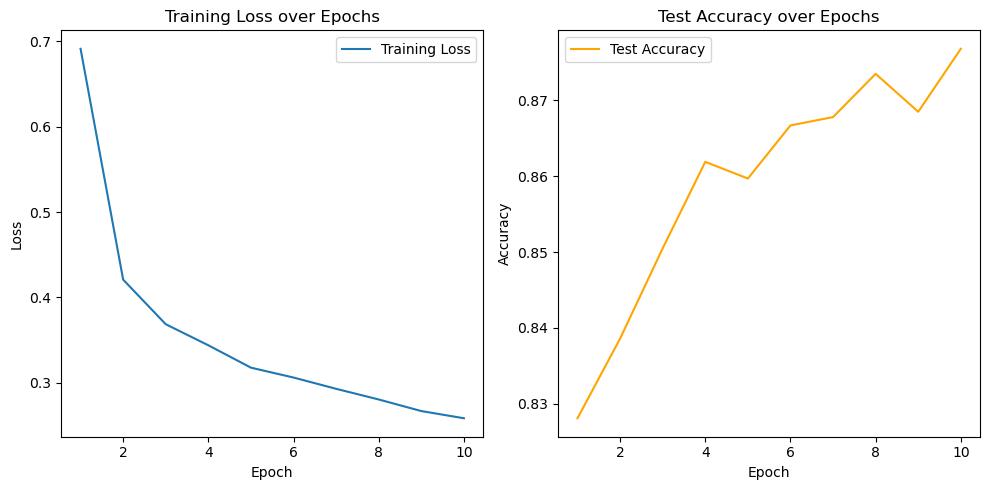

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


# 数据加载和预处理
def load_data(batch_size=64):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    train_dataset = datasets.FashionMNIST(
        root="../data", train=True, download=True, transform=transform
    )
    test_dataset = datasets.FashionMNIST(
        root="../data", train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# 定义多层感知机
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation=nn.ReLU()):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        prev_size = input_size

        # 添加隐藏层
        for size in hidden_sizes:
            self.layers.append(nn.Linear(prev_size, size))
            self.layers.append(activation)
            prev_size = size

        # 添加输出层
        self.layers.append(nn.Linear(prev_size, output_size))

        # 初始化权重
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in self.layers:
            x = layer(x)
        return x


# 训练函数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


# 测试函数
def test(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    return accuracy


# 主函数
def main():
    # 设置设备
    device = torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else  "cpu"
    )
    print(f"Using device: {device}")

    # 加载数据
    train_loader, test_loader = load_data(batch_size=64)

    # 定义模型、损失函数和优化器
    input_size = 28 * 28  # Fashion-MNIST 图像大小是 28x28
    hidden_sizes = [128, 64]
    output_size = 10  # 分类数目
    model = MLP(input_size, hidden_sizes, output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练和测试
    num_epochs = 10
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_accuracy = test(model, test_loader, device)

        train_losses.append(train_loss)
        test_accuracies.append(test_accuracy)

        print(f"Training Loss: {train_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.2f}%")

    # 使用 matplotlib 可视化训练过程
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(
        range(1, num_epochs + 1), test_accuracies, label="Test Accuracy", color="orange"
    )
    plt.title("Test Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()